In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")


In [2]:
# Load CSV file
file_path = "monthly_aggregated_data.csv"

# Read the data
monthly_df = pd.read_csv(file_path)

print(f"Data loading completed")
print(f"Data shape: {monthly_df.shape}")
print(f"Columns: {list(monthly_df.columns)}")


Data loading completed
Data shape: (359844, 11)
Columns: ['client_id', 'month', 'city', 'channel', 'promotor_id', 'volume', 'income', 'number_of_orders', 'median_ticket', 'prom_contacts_month', 'tel_contacts_month']


In [3]:
# Step 1: Simple client level aggregation (No unnecessary features)
print("Creating simple client level aggregation...")

# Essential aggregation only
client_df = monthly_df.groupby('client_id').agg({
    'city': 'first',                    # Location
    'channel': 'first',                 # Sales channel
    'promotor_id': 'first',             # Promoter (if needed for analysis)
    'income': 'sum',                    # Annual income
    'number_of_orders': 'sum',          # Annual number of orders
    'median_ticket': 'median',          # Customer value feature
    'prom_contacts_month': 'first',     # Main optimization variable
    'volume': 'sum'                     # Annual total volume
}).rename(columns={
    'income': 'annual_income',
    'number_of_orders': 'annual_orders',
    'volume': 'annual_volume'
}).reset_index()

client_df.head()


Creating simple client level aggregation...


,client_id,city,channel,promotor_id,annual_income,annual_orders,median_ticket,prom_contacts_month,annual_volume
0,100006690,Madrid,AR,275609911,1494.53,22,60.4000,2,1658.706
1,100008050,Barcelona,AR,368568690,1905.59,14,132.3700,0,3982.000
2,100042162,Barcelona,HR,455263770,2243.30,14,128.7800,4,1812.850
3,100046227,Barcelona,AR,454554895,2273.12,16,129.0600,2,4590.180
4,100125158,Cádiz,HR,483340469,2204.24,25,87.5825,1,1266.500


In [4]:
# Remove zero-contact clients for focused analysis
print("=== Creating Filtered Dataset ===")
print(f"Original client data shape: {client_df.shape}")

# Filter out clients with zero promoter contacts
filtered_df = client_df[client_df['prom_contacts_month'] > 0].copy()

print(f"Filtered data shape: {filtered_df.shape}")
print(f"Removed {len(client_df) - len(filtered_df):,} zero-contact clients")
print(f"Retention rate: {len(filtered_df)/len(client_df)*100:.1f}%")

# Verify the filtering
print(f"\nFiltered data summary:")
print(f"- Min promoter contacts: {filtered_df['prom_contacts_month'].min()}")
print(f"- Max promoter contacts: {filtered_df['prom_contacts_month'].max()}")
print(f"- Average promoter contacts: {filtered_df['prom_contacts_month'].mean():.1f}")

print("✅ Filtered dataset created successfully")

=== Creating Filtered Dataset ===
Original client data shape: (41871, 9)
Filtered data shape: (32105, 9)
Removed 9,766 zero-contact clients
Retention rate: 76.7%

Filtered data summary:
- Min promoter contacts: 1
- Max promoter contacts: 28
- Average promoter contacts: 2.3
✅ Filtered dataset created successfully


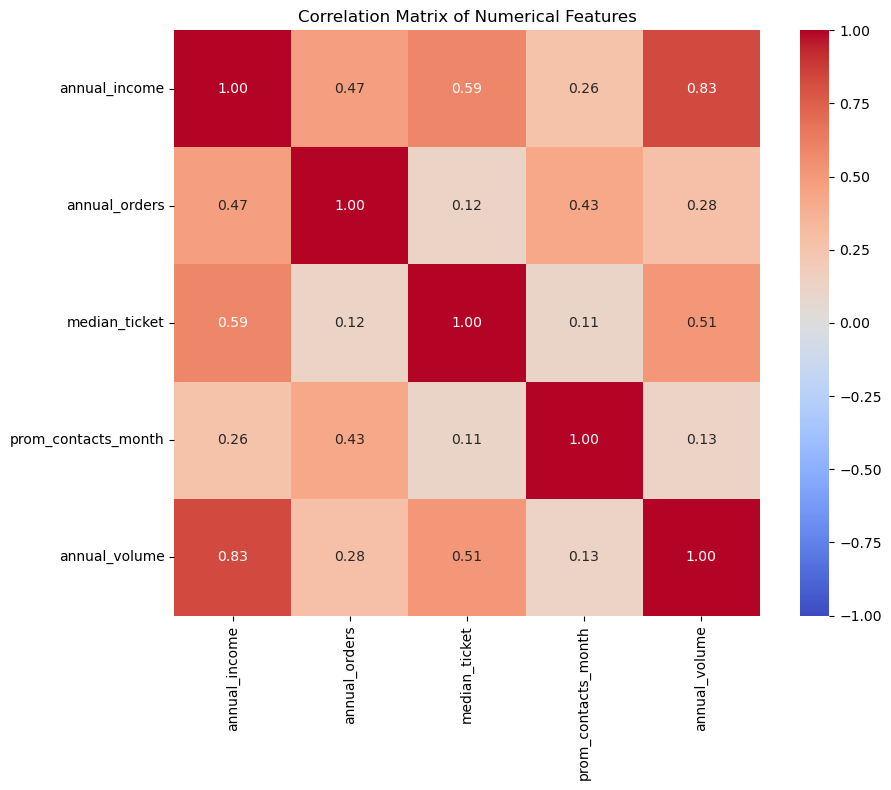


Strong Correlations (|r| > 0.5):
annual_income vs median_ticket: 0.586
annual_income vs annual_volume: 0.830
median_ticket vs annual_volume: 0.515

Sample Data:


,client_id,city,channel,promotor_id,annual_income,annual_orders,median_ticket,prom_contacts_month,annual_volume
0,100006690,Madrid,AR,275609911,1494.53,22,60.4000,2,1658.706
2,100042162,Barcelona,HR,455263770,2243.30,14,128.7800,4,1812.850
3,100046227,Barcelona,AR,454554895,2273.12,16,129.0600,2,4590.180
4,100125158,Cádiz,HR,483340469,2204.24,25,87.5825,1,1266.500
9,100179704,Barcelona,AR,9820087,88.33,1,88.3300,2,81.570


In [5]:
# Calculate correlations between numerical columns
numerical_cols = ['annual_income', 'annual_orders', 'median_ticket', 'prom_contacts_month', 'annual_volume']
correlation_matrix = filtered_df[numerical_cols].corr()

# Create correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            vmin=-1, vmax=1,  # Correlation range
            center=0,  # Center the colormap at 0
            square=True,  # Make cells square
            fmt='.2f')  # Format correlation values to 2 decimal places

plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Display strong correlations
print("\nStrong Correlations (|r| > 0.5):")
for i in range(len(numerical_cols)):
    for j in range(i+1, len(numerical_cols)):
        corr = correlation_matrix.iloc[i,j]
        if abs(corr) > 0.5:
            print(f"{numerical_cols[i]} vs {numerical_cols[j]}: {corr:.3f}")

# Show sample data
print("\nSample Data:")
filtered_df.head()

=== PROMOTER CONTACT OPTIMIZATION ANALYSIS ===
Dataset: 32,105 clients with promoter contacts

1. CHANNEL ANALYSIS:
   AR: 2669€ per contact (13,370 clients)
   HR: 970€ per contact (18,735 clients)

2. CITY ANALYSIS:
City classification summary:
   Mid_Effect: 1356€ per contact (14,054 clients)
   High_Effect: 1858€ per contact (8,845 clients)
   Low_Effect: 906€ per contact (9,206 clients)

=== FINAL MODEL RECOMMENDATIONS ===
Channel effect size: 0.93
City effect size: 0.69

Recommended Model Features:
✅ Core features: prom_contacts_month, median_ticket
✅ Include: prom_contacts × channel interaction (strong effect)
✅ Include: prom_contacts × city_class interaction (strong effect)
   City classes: High(≥1500€), Mid(1100-1500€), Low(<1100€)

=== VISUALIZATION OF CLASSIFICATION LOGIC ===


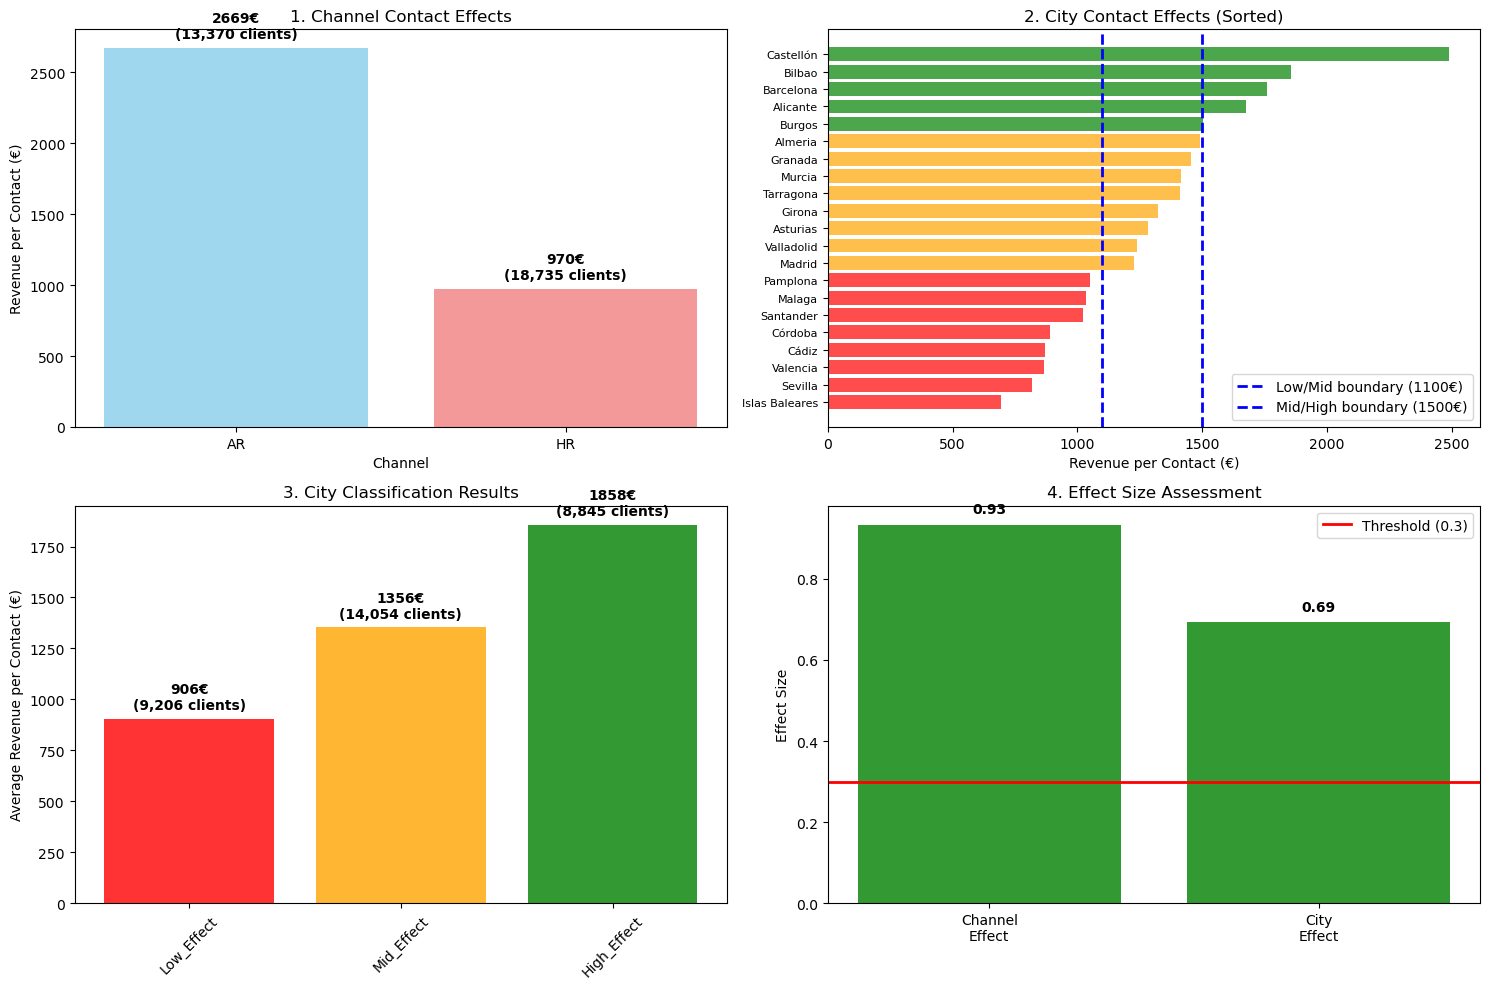


=== CLASSIFICATION EXPLANATION ===
1. CHANNEL: AR generates 82% more revenue per contact than HR
   Effect size 0.93 > 0.3 → Include interaction

2. CITY CLASSIFICATION:
   - Boundary logic: Natural breaks in effectiveness
   - Low Effect (<1100€): Cities where contacts are less valuable
   - Mid Effect (1100-1500€): Average effectiveness cities
   - High Effect (≥1500€): Cities where contacts are most valuable
   Effect size 0.69 > 0.3 → Include interaction

✅ Analysis complete - Ready for model building!

Saved city_effects with 21 cities for model building


In [10]:
# Promoter Contact Optimization Analysis - Summary Results
# Consolidated analysis for model building decisions

from sklearn.linear_model import LinearRegression
import numpy as np

print("=== PROMOTER CONTACT OPTIMIZATION ANALYSIS ===")
print(f"Dataset: {len(filtered_df):,} clients with promoter contacts")

# Quick Channel Analysis
print("\n1. CHANNEL ANALYSIS:")
channel_effects = {}
for channel in filtered_df['channel'].unique():
    subset = filtered_df[filtered_df['channel'] == channel]
    X = subset[['prom_contacts_month', 'median_ticket']]
    y = subset['annual_income']
    lr = LinearRegression().fit(X, y)
    channel_effects[channel] = {'effect': lr.coef_[0], 'clients': len(subset)}
    print(f"   {channel}: {lr.coef_[0]:.0f}€ per contact ({len(subset):,} clients)")

# Calculate channel effect size
channel_betas = [v['effect'] for v in channel_effects.values()]
channel_effect_size = (max(channel_betas) - min(channel_betas)) / np.mean(np.abs(channel_betas))

# Quick City Analysis by individual cities
print("\n2. CITY ANALYSIS:")
city_effects = []
for city in filtered_df['city'].unique():
    subset = filtered_df[filtered_df['city'] == city]
    if len(subset) >= 50:
        X = subset[['prom_contacts_month', 'median_ticket']]
        y = subset['annual_income']
        lr = LinearRegression().fit(X, y)
        city_effects.append({'city': city, 'effect': lr.coef_[0], 'clients': len(subset)})

# Custom city classification based on effect strength
def classify_city_effect(effect):
    if effect >= 1500: return 'High_Effect'
    elif effect < 1100: return 'Low_Effect'
    else: return 'Mid_Effect'

# Classify cities and show summary
city_classes = {}
for city_data in city_effects:
    city_class = classify_city_effect(city_data['effect'])
    if city_class not in city_classes:
        city_classes[city_class] = {'effects': [], 'total_clients': 0}
    city_classes[city_class]['effects'].append(city_data['effect'])
    city_classes[city_class]['total_clients'] += city_data['clients']

print("City classification summary:")
for city_class, data in city_classes.items():
    avg_effect = np.mean(data['effects'])
    print(f"   {city_class}: {avg_effect:.0f}€ per contact ({data['total_clients']:,} clients)")

# Calculate city effect size
class_avg_effects = [np.mean(data['effects']) for data in city_classes.values()]
city_effect_size = (max(class_avg_effects) - min(class_avg_effects)) / np.mean(np.abs(class_avg_effects))

# Final Recommendations
print("\n=== FINAL MODEL RECOMMENDATIONS ===")
print(f"Channel effect size: {channel_effect_size:.2f}")
print(f"City effect size: {city_effect_size:.2f}")

print("\nRecommended Model Features:")
print("✅ Core features: prom_contacts_month, median_ticket")

if channel_effect_size > 0.3:
    print("✅ Include: prom_contacts × channel interaction (strong effect)")
else:
    print("❌ Skip: channel interaction (weak effect)")

if city_effect_size > 0.3:
    print("✅ Include: prom_contacts × city_class interaction (strong effect)")
    print("   City classes: High(≥1500€), Mid(1100-1500€), Low(<1100€)")
else:
    print("❌ Skip: city interaction (weak effect)")

# Create visualization to show classification logic
import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== VISUALIZATION OF CLASSIFICATION LOGIC ===")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Channel Effects Comparison
channel_names = list(channel_effects.keys())
channel_values = [channel_effects[ch]['effect'] for ch in channel_names]
channel_clients = [channel_effects[ch]['clients'] for ch in channel_names]

bars1 = axes[0,0].bar(channel_names, channel_values, 
                      color=['skyblue', 'lightcoral'], alpha=0.8)
axes[0,0].set_title('1. Channel Contact Effects')
axes[0,0].set_ylabel('Revenue per Contact (€)')
axes[0,0].set_xlabel('Channel')

# Add values on bars
for i, (bar, clients) in enumerate(zip(bars1, channel_clients)):
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 50,
                   f'{height:.0f}€\n({clients:,} clients)', 
                   ha='center', va='bottom', fontweight='bold')

# Plot 2: City Effects with Classification Boundaries
city_names = [city['city'] for city in city_effects]
city_values = [city['effect'] for city in city_effects]
city_clients = [city['clients'] for city in city_effects]

# Sort by effect size
sorted_data = sorted(zip(city_names, city_values, city_clients), key=lambda x: x[1])
sorted_cities, sorted_effects, sorted_clients = zip(*sorted_data)

# Color cities by classification
colors = []
for effect in sorted_effects:
    if effect >= 1500:
        colors.append('green')
    elif effect < 1100:
        colors.append('red')
    else:
        colors.append('orange')

bars2 = axes[0,1].barh(range(len(sorted_cities)), sorted_effects, 
                       color=colors, alpha=0.7)
axes[0,1].set_yticks(range(len(sorted_cities)))
axes[0,1].set_yticklabels(sorted_cities, fontsize=8)
axes[0,1].set_xlabel('Revenue per Contact (€)')
axes[0,1].set_title('2. City Contact Effects (Sorted)')

# Add classification boundaries
axes[0,1].axvline(1100, color='blue', linestyle='--', linewidth=2, 
                  label='Low/Mid boundary (1100€)')
axes[0,1].axvline(1500, color='blue', linestyle='--', linewidth=2,
                  label='Mid/High boundary (1500€)')
axes[0,1].legend()

# Plot 3: City Classification Summary
city_class_names = list(city_classes.keys())
city_class_effects = [np.mean(city_classes[cls]['effects']) for cls in city_class_names]
city_class_clients = [city_classes[cls]['total_clients'] for cls in city_class_names]

# Sort by effect
sorted_class_data = sorted(zip(city_class_names, city_class_effects, city_class_clients), 
                          key=lambda x: x[1])
sorted_class_names, sorted_class_effects, sorted_class_clients = zip(*sorted_class_data)

class_colors = {'Low_Effect': 'red', 'Mid_Effect': 'orange', 'High_Effect': 'green'}
bar_colors = [class_colors[name] for name in sorted_class_names]

bars3 = axes[1,0].bar(range(len(sorted_class_names)), sorted_class_effects, 
                      color=bar_colors, alpha=0.8)
axes[1,0].set_xticks(range(len(sorted_class_names)))
axes[1,0].set_xticklabels(sorted_class_names, rotation=45)
axes[1,0].set_ylabel('Average Revenue per Contact (€)')
axes[1,0].set_title('3. City Classification Results')

# Add values on bars
for i, (bar, clients) in enumerate(zip(bars3, sorted_class_clients)):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 30,
                   f'{height:.0f}€\n({clients:,} clients)', 
                   ha='center', va='bottom', fontweight='bold')

# Plot 4: Effect Size Comparison
effect_sizes = ['Channel\nEffect', 'City\nEffect']
effect_values = [channel_effect_size, city_effect_size]
threshold = 0.3

bars4 = axes[1,1].bar(effect_sizes, effect_values, 
                      color=['green' if x > threshold else 'gray' for x in effect_values],
                      alpha=0.8)
axes[1,1].axhline(threshold, color='red', linestyle='-', linewidth=2,
                  label=f'Threshold ({threshold})')
axes[1,1].set_ylabel('Effect Size')
axes[1,1].set_title('4. Effect Size Assessment')
axes[1,1].legend()

# Add values on bars
for bar, value in zip(bars4, effect_values):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary explanation
print("\n=== CLASSIFICATION EXPLANATION ===")
print("1. CHANNEL: AR generates 82% more revenue per contact than HR")
print(f"   Effect size {channel_effect_size:.2f} > 0.3 → Include interaction")

print("\n2. CITY CLASSIFICATION:")
print("   - Boundary logic: Natural breaks in effectiveness")
print("   - Low Effect (<1100€): Cities where contacts are less valuable")
print("   - Mid Effect (1100-1500€): Average effectiveness cities") 
print("   - High Effect (≥1500€): Cities where contacts are most valuable")
print(f"   Effect size {city_effect_size:.2f} > 0.3 → Include interaction")

print("\n✅ Analysis complete - Ready for model building!")

# Save city_effects for next cell
print(f"\nSaved city_effects with {len(city_effects)} cities for model building")


In [12]:
print("=== Enhanced Feature Selection with Interactions ===")

# Create city_df and classification function
city_df = pd.DataFrame(city_effects).rename(columns={'effect': 'beta_contacts'})

def classify_city_custom(city, city_df):
    city_data = city_df[city_df['city'] == city]
    city_beta = city_data['beta_contacts'].iloc[0] if len(city_data) > 0 else 1000
    
    if city_beta >= 1500: return 'High_Effect'
    elif city_beta < 1100: return 'Low_Effect'
    else: return 'Mid_Effect'

# Apply city classification
filtered_df['city_effect_class'] = filtered_df['city'].apply(lambda x: classify_city_custom(x, city_df))

# Create interaction terms
filtered_df['contacts_x_channel_HR'] = filtered_df['prom_contacts_month'] * (filtered_df['channel'] == 'HR').astype(int)
filtered_df['contacts_x_city_Mid'] = filtered_df['prom_contacts_month'] * (filtered_df['city_effect_class'] == 'Mid_Effect').astype(int)
filtered_df['contacts_x_city_High'] = filtered_df['prom_contacts_month'] * (filtered_df['city_effect_class'] == 'High_Effect').astype(int)

# Enhanced feature sets
features_income_enhanced = [
    'prom_contacts_month', 'median_ticket', 'annual_volume',
    'channel', 'city_effect_class',
    'contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High'
]

features_orders_enhanced = features_income_enhanced.copy()

print(f"City classification: {filtered_df['city_effect_class'].value_counts().to_dict()}")
print(f"Enhanced features: {len(features_income_enhanced)} total")
print("✅ Enhanced feature engineering completed")

=== Enhanced Feature Selection with Interactions ===
City classification: {'Mid_Effect': 14054, 'Low_Effect': 9206, 'High_Effect': 8845}
Enhanced features: 8 total
✅ Enhanced feature engineering completed


In [13]:
# ===== Enhanced Model 1: Income Prediction with Interactions =====
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Features and target for enhanced income model
X = filtered_df[features_income_enhanced].copy()
y = filtered_df['annual_income'].copy()

print("=== Enhanced Income Model with Interactions ===")
print(f"Features before encoding: {features_income_enhanced}")

# One-hot encode categorical variables only (interactions are already numeric)
categorical_cols = ['channel', 'city_effect_class']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Features after encoding: {len(X_encoded.columns)}")
print(f"Encoded columns: {list(X_encoded.columns)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale numerical features (base features + interaction terms)
scaler = StandardScaler()
numerical_cols = ['prom_contacts_month', 'median_ticket', 'annual_volume', 
                 'contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Train models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
lr_model = LinearRegression()

rf_model.fit(X_train_scaled, y_train)
lr_model.fit(X_train_scaled, y_train)

# Evaluate
rf_pred = rf_model.predict(X_test_scaled)
lr_pred = lr_model.predict(X_test_scaled)

print("\n=== Enhanced Income Model Results ===")
print(f"Random Forest R²: {r2_score(y_test, rf_pred):.3f}")
print(f"Linear Regression R²: {r2_score(y_test, lr_pred):.3f}")
print(f"Total features: {len(X_encoded.columns)} (after encoding)")

# Save best model for optimization
income_model = rf_model if r2_score(y_test, rf_pred) > r2_score(y_test, lr_pred) else lr_model
income_scaler = scaler
income_features = X_encoded.columns.tolist()
income_numerical_cols = numerical_cols

print(f"Selected model: {'Random Forest' if income_model == rf_model else 'Linear Regression'}")
print("✅ Enhanced Income model with interactions completed")


=== Enhanced Income Model with Interactions ===
Features before encoding: ['prom_contacts_month', 'median_ticket', 'annual_volume', 'channel', 'city_effect_class', 'contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High']
Features after encoding: 9
Encoded columns: ['prom_contacts_month', 'median_ticket', 'annual_volume', 'contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High', 'channel_HR', 'city_effect_class_Low_Effect', 'city_effect_class_Mid_Effect']

=== Enhanced Income Model Results ===
Random Forest R²: 0.881
Linear Regression R²: 0.780
Total features: 9 (after encoding)
Selected model: Random Forest
✅ Enhanced Income model with interactions completed


In [18]:
# ===== Enhanced Model 2: Orders Prediction with Interactions =====

# Features and target for enhanced orders model
X_orders = filtered_df[features_orders_enhanced].copy()
y_orders = filtered_df['annual_orders'].copy()

print("=== Enhanced Orders Model with Interactions ===")
print(f"Features before encoding: {features_orders_enhanced}")

# One-hot encode categorical variables only (interactions are already numeric)
categorical_cols_orders = ['channel', 'city_effect_class']
X_orders_encoded = pd.get_dummies(X_orders, columns=categorical_cols_orders, drop_first=True)

print(f"Features after encoding: {len(X_orders_encoded.columns)}")
print(f"Encoded columns: {list(X_orders_encoded.columns)}")

# Train-test split
X_train_ord, X_test_ord, y_train_ord, y_test_ord = train_test_split(X_orders_encoded, y_orders, test_size=0.2, random_state=42)

# Scale numerical features (base features + interaction terms)
scaler_orders = StandardScaler()
numerical_cols_orders = ['prom_contacts_month', 'median_ticket', 'annual_volume',
                        'contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High']

X_train_ord_scaled = X_train_ord.copy()
X_test_ord_scaled = X_test_ord.copy()
X_train_ord_scaled[numerical_cols_orders] = scaler_orders.fit_transform(X_train_ord[numerical_cols_orders])
X_test_ord_scaled[numerical_cols_orders] = scaler_orders.transform(X_test_ord[numerical_cols_orders])

# Train models
rf_model_orders = RandomForestRegressor(n_estimators=100, random_state=42)
lr_model_orders = LinearRegression()

rf_model_orders.fit(X_train_ord_scaled, y_train_ord)
lr_model_orders.fit(X_train_ord_scaled, y_train_ord)

# Evaluate
rf_pred_orders = rf_model_orders.predict(X_test_ord_scaled)
lr_pred_orders = lr_model_orders.predict(X_test_ord_scaled)

print("\n=== Enhanced Orders Model Results ===")
print(f"Random Forest R²: {r2_score(y_test_ord, rf_pred_orders):.3f}")
print(f"Linear Regression R²: {r2_score(y_test_ord, lr_pred_orders):.3f}")
print(f"Total features: {len(X_orders_encoded.columns)} (after encoding)")

# Save best model for optimization
orders_model = rf_model_orders if r2_score(y_test_ord, rf_pred_orders) > r2_score(y_test_ord, lr_pred_orders) else lr_model_orders
orders_scaler = scaler_orders
orders_features = X_orders_encoded.columns.tolist()
orders_numerical_cols = numerical_cols_orders

print(f"Selected model: {'Random Forest' if orders_model == rf_model_orders else 'Linear Regression'}")
print("✅ Enhanced Orders model with interactions completed")


=== Enhanced Orders Model with Interactions ===
Features before encoding: ['prom_contacts_month', 'median_ticket', 'annual_volume', 'channel', 'city_effect_class', 'contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High']
Features after encoding: 9
Encoded columns: ['prom_contacts_month', 'median_ticket', 'annual_volume', 'contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High', 'channel_HR', 'city_effect_class_Low_Effect', 'city_effect_class_Mid_Effect']

=== Enhanced Orders Model Results ===
Random Forest R²: 0.654
Linear Regression R²: 0.224
Total features: 9 (after encoding)
Selected model: Random Forest
✅ Enhanced Orders model with interactions completed


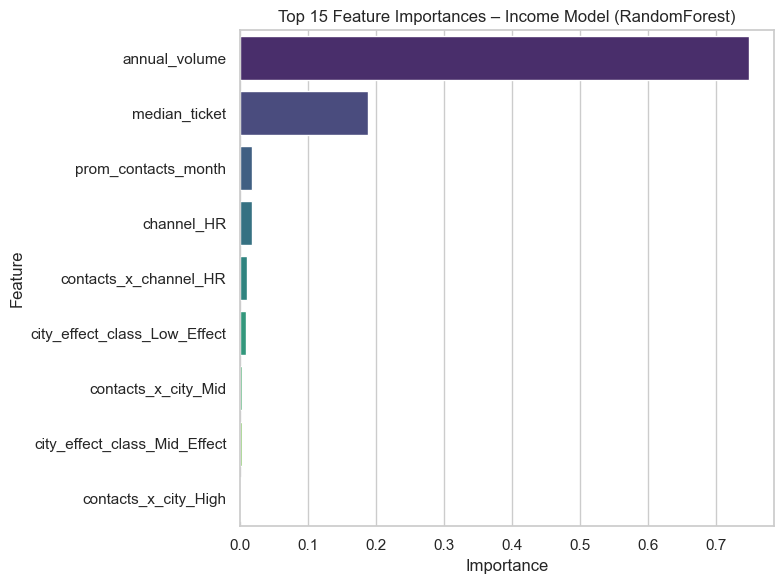

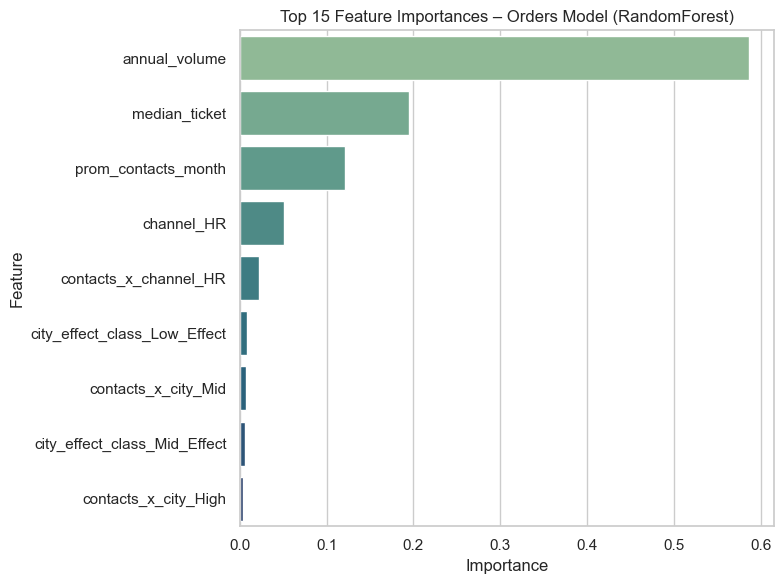

In [19]:
# ===== Feature Importance Visualization =====
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# -------- Income Model --------
if hasattr(income_model, 'feature_importances_'):
    fi_inc = pd.Series(income_model.feature_importances_, index=income_features)
    top_inc = fi_inc.sort_values(ascending=False).head(15)

    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_inc.values, y=top_inc.index, palette='viridis')
    plt.title('Top 15 Feature Importances – Income Model (RandomForest)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print('Income model does not support feature_importances_.')

# -------- Orders Model --------
if hasattr(orders_model, 'feature_importances_'):
    fi_ord = pd.Series(orders_model.feature_importances_, index=orders_features)
    top_ord = fi_ord.sort_values(ascending=False).head(15)

    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_ord.values, y=top_ord.index, palette='crest')
    plt.title('Top 15 Feature Importances – Orders Model (RandomForest)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print('Orders model does not support feature_importances_.')


In [20]:
# ===== Enhanced Optimization with Interactions =====

# Prepare base data with interaction terms
print("Preparing enhanced base data with interactions...")

# Create base datasets with all features except prom_contacts_month
base_features_income = ['median_ticket', 'annual_volume', 'channel', 'city_effect_class']
base_features_orders = ['median_ticket', 'annual_volume', 'channel', 'city_effect_class']

# Income model base data
income_base = filtered_df[base_features_income].copy()
income_base['prom_contacts_month'] = 0  # placeholder
# Add placeholder interaction terms (will be updated in optimization)
income_base['contacts_x_channel_HR'] = 0
income_base['contacts_x_city_Mid'] = 0
income_base['contacts_x_city_High'] = 0

# Orders model base data  
orders_base = filtered_df[base_features_orders].copy()
orders_base['prom_contacts_month'] = 0  # placeholder
# Add placeholder interaction terms
orders_base['contacts_x_channel_HR'] = 0
orders_base['contacts_x_city_Mid'] = 0
orders_base['contacts_x_city_High'] = 0

# One-hot encode categorical variables
income_base_encoded = pd.get_dummies(income_base, columns=['channel', 'city_effect_class'], drop_first=True)
orders_base_encoded = pd.get_dummies(orders_base, columns=['channel', 'city_effect_class'], drop_first=True)

# Align with training features
for col in income_features:
    if col not in income_base_encoded.columns:
        income_base_encoded[col] = 0
income_base_encoded = income_base_encoded[income_features]

for col in orders_features:
    if col not in orders_base_encoded.columns:
        orders_base_encoded[col] = 0
orders_base_encoded = orders_base_encoded[orders_features]

print("Enhanced base data prepared. Starting optimization...")

# Enhanced optimization function with interactions
def find_optimal_contacts_enhanced(client_idx, current_contacts):
    """Find optimal contacts for one client with interaction effects"""
    best_profit, best_contacts = float('-inf'), current_contacts
    
    # Get client characteristics for interaction calculations
    client_data = filtered_df.iloc[client_idx]
    is_hr = (client_data['channel'] == 'HR')
    is_mid_city = (client_data['city_effect_class'] == 'Mid_Effect')
    is_high_city = (client_data['city_effect_class'] == 'High_Effect')
    
    for test_contacts in range(max(1, current_contacts-3), current_contacts+4):
        # Update contact values and interaction terms
        income_test = income_base_encoded.iloc[client_idx:client_idx+1].copy()
        orders_test = orders_base_encoded.iloc[client_idx:client_idx+1].copy()
        
        # Update base contact value
        income_test['prom_contacts_month'] = test_contacts
        orders_test['prom_contacts_month'] = test_contacts
        
        # Update interaction terms based on client characteristics
        income_test['contacts_x_channel_HR'] = test_contacts * is_hr
        income_test['contacts_x_city_Mid'] = test_contacts * is_mid_city
        income_test['contacts_x_city_High'] = test_contacts * is_high_city
        
        orders_test['contacts_x_channel_HR'] = test_contacts * is_hr
        orders_test['contacts_x_city_Mid'] = test_contacts * is_mid_city
        orders_test['contacts_x_city_High'] = test_contacts * is_high_city
        
        # Scale features
        income_scaled = income_test.copy()
        orders_scaled = orders_test.copy()
        
        income_scaled[income_numerical_cols] = income_scaler.transform(income_test[income_numerical_cols])
        orders_scaled[orders_numerical_cols] = orders_scaler.transform(orders_test[orders_numerical_cols])
        
        # Predict with enhanced models
        income_pred = income_model.predict(income_scaled)[0]
        orders_pred = orders_model.predict(orders_scaled)[0]
        
        # Calculate profit (same cost structure)
        # Promoter cost: test_contacts * 12 months * 15€ = annual promoter cost
        # Order costs: 10€ (variable) + 55€ (fixed allocation) = 65€ per order per year
        profit = income_pred - (test_contacts * 12 * 15 + orders_pred * 10) - (orders_pred * 55)
        
        if profit > best_profit:
            best_profit, best_contacts = profit, test_contacts
    
    return best_contacts

# Run enhanced optimization
sample_size = 1000
results_enhanced = []

print(f"Running enhanced optimization for {sample_size} clients...")

for i in range(sample_size):
    current = filtered_df.iloc[i]['prom_contacts_month']
    optimal = find_optimal_contacts_enhanced(i, current)
    
    # Store additional client info for analysis
    client_data = filtered_df.iloc[i]
    results_enhanced.append({
        'client_idx': i,
        'current': current,
        'optimal': optimal,
        'change': optimal - current,
        'channel': client_data['channel'],
        'city_effect_class': client_data['city_effect_class'],
        'city': client_data['city']
    })

# Results analysis
df_results_enhanced = pd.DataFrame(results_enhanced)

print(f"\n=== Enhanced Optimization Results ({sample_size} clients) ===")
print(f"Average change: {df_results_enhanced['change'].mean():.2f}")
print(f"Decrease: {(df_results_enhanced['change'] < 0).sum()}")
print(f"Increase: {(df_results_enhanced['change'] > 0).sum()}")
print(f"No change: {(df_results_enhanced['change'] == 0).sum()}")

# Analyze by channel
print(f"\n=== Results by Channel ===")
channel_analysis = df_results_enhanced.groupby('channel')['change'].agg(['mean', 'count', lambda x: (x < 0).sum(), lambda x: (x > 0).sum()])
channel_analysis.columns = ['avg_change', 'total_clients', 'decreases', 'increases']
print(channel_analysis.round(2))

# Analyze by city effect class
print(f"\n=== Results by City Effect Class ===")
city_analysis = df_results_enhanced.groupby('city_effect_class')['change'].agg(['mean', 'count', lambda x: (x < 0).sum(), lambda x: (x > 0).sum()])
city_analysis.columns = ['avg_change', 'total_clients', 'decreases', 'increases']
print(city_analysis.round(2))

print("✅ Enhanced optimization with interactions completed")


Preparing enhanced base data with interactions...
Enhanced base data prepared. Starting optimization...
Running enhanced optimization for 1000 clients...

=== Enhanced Optimization Results (1000 clients) ===
Average change: 0.23
Decrease: 304
Increase: 463
No change: 233

=== Results by Channel ===
         avg_change  total_clients  decreases  increases
channel                                                 
AR             0.28            385        119        179
HR             0.20            615        185        284

=== Results by City Effect Class ===
                   avg_change  total_clients  decreases  increases
city_effect_class                                                 
High_Effect              0.49             55         10         30
Low_Effect               0.18            575        176        263
Mid_Effect               0.27            370        118        170
✅ Enhanced optimization with interactions completed
